##Data Preparation for Short Term Solar Energy Production Forecasting
This notebook uses data from the Kaggle dataset at this link: https://www.kaggle.com/competitions/ams-2014-solar-energy-prediction-contest/data which was part of a competition held in 2014.

To access this dataset Kaggle has too be installed and authentication has to be provided through an access token. The next cell helps run the setup process. For any support please refer to: https://www.kaggle.com/discussions/general/74235

In [ ]:
#Uncomment the lines required to install and update the access to Kaggle
# !pip install kaggle
# from google.colab import files
# files.upload()
# ! mkdir ~/.kaggle
# ! cp '/content/kaggle.json' ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

Archive:  /content/ams-2014-solar-energy-prediction-contest.zip
  inflating: /content/drive/MyDrive/ams-2014-solar-energy-prediction/gefs_elevations.nc  
  inflating: /content/drive/MyDrive/ams-2014-solar-energy-prediction/gefs_test.tar.gz  
  inflating: /content/drive/MyDrive/ams-2014-solar-energy-prediction/gefs_test.zip  
  inflating: /content/drive/MyDrive/ams-2014-solar-energy-prediction/gefs_train.tar.gz  
  inflating: /content/drive/MyDrive/ams-2014-solar-energy-prediction/gefs_train.zip  
  inflating: /content/drive/MyDrive/ams-2014-solar-energy-prediction/sampleSubmission.csv  
  inflating: /content/drive/MyDrive/ams-2014-solar-energy-prediction/solar_training_199401_200712.csv  
  inflating: /content/drive/MyDrive/ams-2014-solar-energy-prediction/station_info.csv  
  inflating: /content/drive/MyDrive/ams-2014-solar-energy-prediction/test.csv  
  inflating: /content/drive/MyDrive/ams-2014-solar-energy-prediction/train.csv  


In [ ]:
#Download dataset from Kaggle and extract files to local directory
# !kaggle competitions download -c ams-2014-solar-energy-prediction-contest
!unzip '/content/ams-2014-solar-energy-prediction-contest.zip' -d '/content/drive/MyDrive/ams-2014-solar-energy-prediction/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Install required libraries
!pip install netCDF4
!pip install statsmodels
!pip install contextily==1.2.0
!pip install haversine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 74.5 MB/s eta 0:00:00


In [ ]:
#Load required libraries
from netCDF4 import Dataset
from os import listdir
import tarfile
import zipfile
import itertools
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import netCDF4
from datetime import datetime

#Please update this root directory path to the path where the files were extracted
root_dir = '/content/drive/MyDrive/ams-2014-solar-energy-prediction/'

### Data Locations

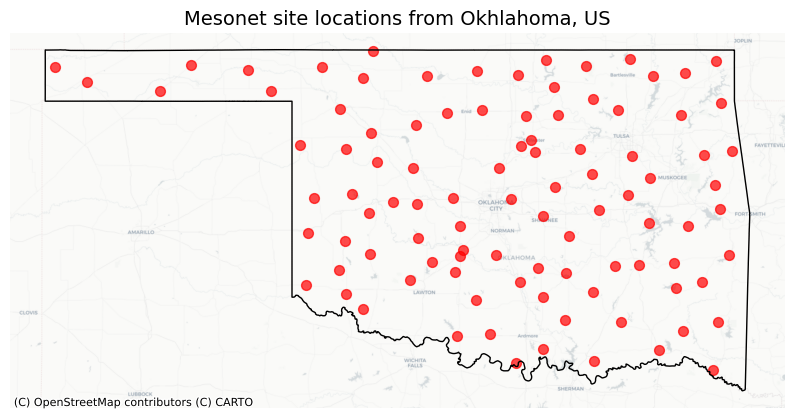

In [ ]:
#Visualise Mesonet locations
df_mesonet_loc = pd.read_csv(f'{root_dir}/station_info.csv')
gdf = gpd.GeoDataFrame(df_mesonet_loc, geometry=gpd.points_from_xy(df_mesonet_loc["elon"], df_mesonet_loc["nlat"]), crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)
url = "https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json"
world = gpd.read_file(url)
states = world[world["NAME"] == "Oklahoma"]

gdf = gdf.to_crs(epsg=3857)
states = states.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 8))
states.boundary.plot(ax=ax, linewidth=1, edgecolor="black")
gdf.plot(ax=ax, markersize=50, color="red", alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.title("Mesonet site locations from Okhlahoma, US", fontsize=14)

plt.show()

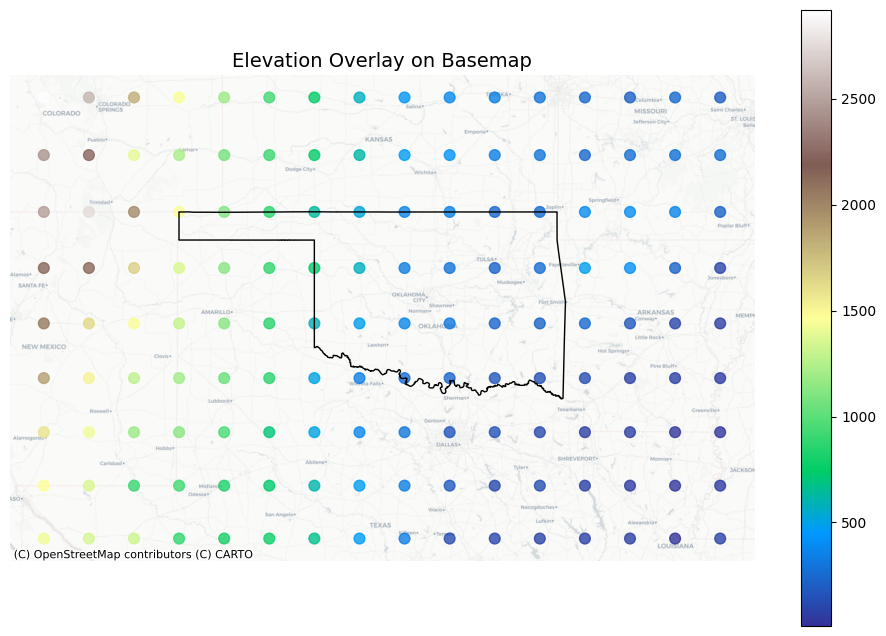

In [ ]:
#Visualise elevations
elevations_nc = Dataset(f'{root_dir}/gefs_elevations.nc')
elev_ctrl = elevations_nc.variables["elevation_control"][:]
elev_pert = elevations_nc.variables["elevation_perturbation"][:]
lat = elevations_nc.variables["latitude"][:]
lon = elevations_nc.variables["longitude"][:]

if lat.ndim == 1 and lon.ndim == 1:
    lon, lat = np.meshgrid(lon, lat)

flat_lat = lat.flatten()
flat_lon = lon.flatten()
flat_elev = elev_ctrl.flatten()

df = pd.DataFrame({
    "latitude": flat_lat,
    "longitude": flat_lon,
    "elevation": flat_elev
})
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(column="elevation", cmap="terrain", ax=ax, legend=True, markersize=60, alpha=0.8)
states.boundary.plot(ax=ax, linewidth=1, edgecolor="black")
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)  # Choose your preferred basemap
ax.set_axis_off()
plt.title("Elevation Overlay on Basemap", fontsize=14)
plt.show()

### Extraction of Data from netCDF files

In [ ]:
#Load netcdf files, separate variable and add solar power as labels
train_path = f'{root_dir}/gefs_train/'

# file_train = tarfile.open(f'{root_dir}/gefs_train.tar.gz')
# file_train.extractall(train_path)
# file_train.close()

#Precipitation Water
nc_pwat_eatm_latlon = Dataset(f'{train_path}/train/pwat_eatm_latlon_subset_19940101_20071231.nc')
#Accumulated Precipitation at Surface
nc_apcp_sfc_latlon = Dataset(f'{train_path}/train/apcp_sfc_latlon_subset_19940101_20071231.nc')
#Downward long-wave radiative flux average at the surface
nc_dlwrf_sfc_latlon = Dataset(f'{train_path}/train/dlwrf_sfc_latlon_subset_19940101_20071231.nc')
#Downward short-wave radiative flux average at the surface
nc_dswrf_sfc_latlon = Dataset(f'{train_path}/train/dswrf_sfc_latlon_subset_19940101_20071231.nc')
#Air pressure at mean sea level
nc_pres_msl_latlon = Dataset(f'{train_path}/train/pres_msl_latlon_subset_19940101_20071231.nc')
#Specific Humidity at 2 m above ground
nc_spfh_2m_latlon = Dataset(f'{train_path}/train/spfh_2m_latlon_subset_19940101_20071231.nc')
#Total cloud cover over the entire depth of the atmosphere
nc_tcdc_eatm_latlon = Dataset(f'{train_path}/train/tcdc_eatm_latlon_subset_19940101_20071231.nc')
#Total column-integrated condensate over the entire atmosphere
nc_tcolc_eatm_latlon = Dataset(f'{train_path}/train/tcolc_eatm_latlon_subset_19940101_20071231.nc')
#Maximum Temperature over the past 3 hours at 2 m above the ground
nc_tmax_2m_latlon = Dataset(f'{train_path}/train/tmax_2m_latlon_subset_19940101_20071231.nc')
#Mininmum Temperature over the past 3 hours at 2 m above the grounde
nc_tmin_2m_latlon = Dataset(f'{train_path}/train/tmin_2m_latlon_subset_19940101_20071231.nc')
# Current temperature at 2 m above the ground
nc_tmp_2m_latlon = Dataset(f'{train_path}/train/tmp_2m_latlon_subset_19940101_20071231.nc')
# Temperature of the surface
nc_tmp_sfc_latlon = Dataset(f'{train_path}/train/tmp_sfc_latlon_subset_19940101_20071231.nc')
# Upward long-wave radiation at the surface
nc_ulwrf_sfc_latlon = Dataset(f'{train_path}/train/ulwrf_sfc_latlon_subset_19940101_20071231.nc')
# Upward long-wave radiation at the top of the atmosphere
nc_ulwrf_tatm_latlon = Dataset(f'{train_path}/train/ulwrf_tatm_latlon_subset_19940101_20071231.nc')
# Upward short-wave radiation at the surface
nc_uswrf_sfc_latlon = Dataset(f'{train_path}/train/uswrf_sfc_latlon_subset_19940101_20071231.nc')
print(nc_tcdc_eatm_latlon.variables)

{'time': <class 'netCDF4.Variable'>
float64 time(time)
    long_name: Time
    units: hours since 1800-01-01 00:00:00
    axis: T
unlimited dimensions: 
current shape = (5113,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'intTime': <class 'netCDF4.Variable'>
int32 intTime(time)
    long_name: time as an integer (YYYYMMDDHH)
unlimited dimensions: 
current shape = (5113,)
filling on, default _FillValue of -2147483647 used, 'lat': <class 'netCDF4.Variable'>
float32 lat(lat)
    long_name: Latitude
    standard_name: latitude
    units: degrees_north
    actual_range: [31. 39.]
    axis: Y
unlimited dimensions: 
current shape = (9,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lon': <class 'netCDF4.Variable'>
float32 lon(lon)
    long_name: Longitude
    standard_name: longitude
    units: degrees_east
    actual_range: [254. 269.]
    axis: X
unlimited dimensions: 
current shape = (16,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'ens'

###Visualising single point forecast for multiple parameters

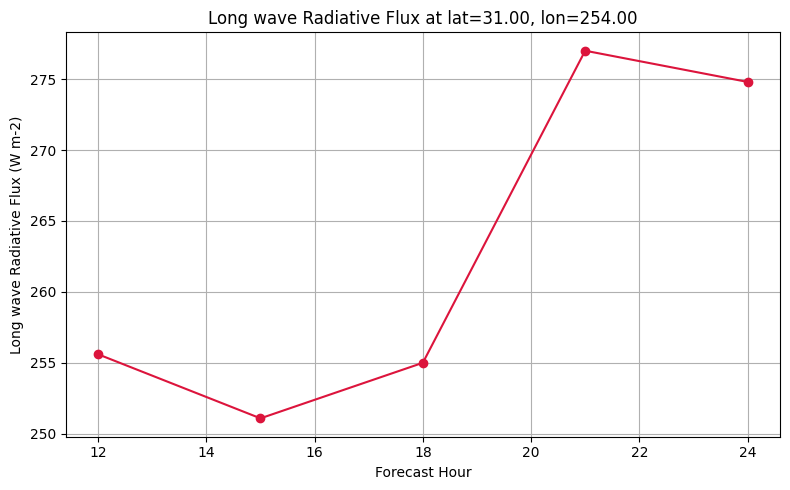

In [ ]:
ds = nc_ulwrf_tatm_latlon

temp = ds.variables["Upward_Long-Wave_Rad_Flux"]
fhour = ds.variables["fhour"][:]  # forecast hours
lat = ds.variables["lat"][:]
lon = ds.variables["lon"][:]
for lat_idx, lon_idx in itertools.product(range(len(lat)), range(len(lon))):
  # Extract temps over forecast hours for time=0 and ens=0
  temp_series = temp[0, 0, :, lat_idx, lon_idx]  # Convert to °C

  # Plot
  plt.figure(figsize=(8, 5))
  plt.plot(fhour, temp_series, marker='o', linestyle='-', color='crimson')
  plt.title(f"Long wave Radiative Flux at lat={lat[lat_idx]:.2f}, lon={lon[lon_idx]:.2f}")
  plt.xlabel("Forecast Hour")
  plt.ylabel("Long wave Radiative Flux (W m-2)")
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  break


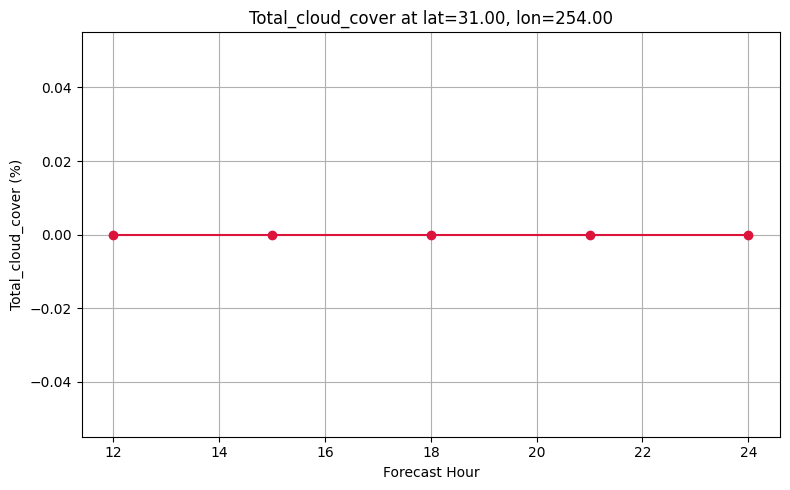

In [ ]:
# for var in nc_tmp_2m_latlon.variables.values():
#     print(var)
#     print("--"*50)

# Load dataset
ds = nc_tcdc_eatm_latlon

temp = ds.variables["Total_cloud_cover"]
fhour = ds.variables["fhour"][:]  # forecast hours
lat = ds.variables["lat"][:]
lon = ds.variables["lon"][:]
for lat_idx, lon_idx in itertools.product(range(len(lat)), range(len(lon))):
  # Extract temps over forecast hours for time=0 and ens=0
  temp_series = temp[0, 0, :, lat_idx, lon_idx]   # Convert to °C

  # Plot
  plt.figure(figsize=(8, 5))
  plt.plot(fhour, temp_series, marker='o', linestyle='-', color='crimson')
  plt.title(f"Total_cloud_cover at lat={lat[lat_idx]:.2f}, lon={lon[lon_idx]:.2f}")
  plt.xlabel("Forecast Hour")
  plt.ylabel("Total_cloud_cover (%)")
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  break


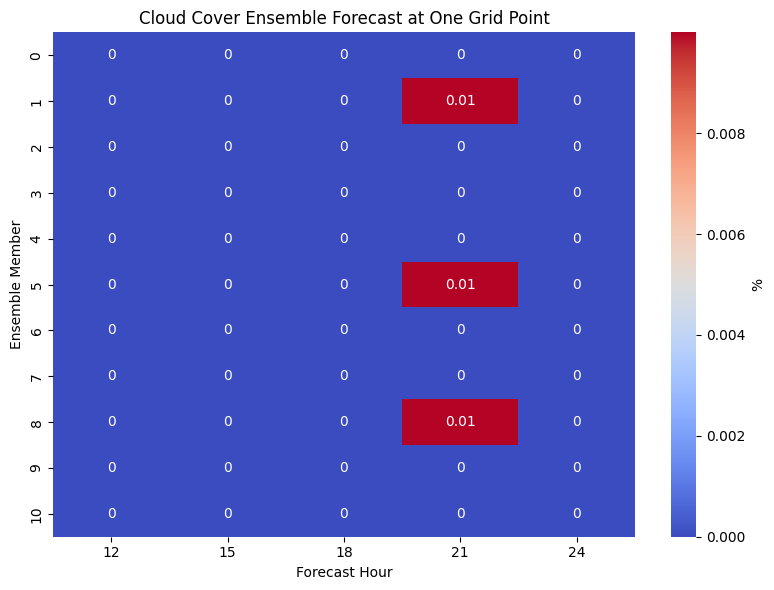

In [ ]:
import seaborn as sns
import numpy as np

# Extract data: time=0, all ensembles, all forecast hours at one point
temps = temp[0, :, :, lat_idx, lon_idx]  # shape (ens, fhour)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(temps, annot=True, xticklabels=fhour, cmap="coolwarm", cbar_kws={"label": "%"})
plt.xlabel("Forecast Hour")
plt.ylabel("Ensemble Member")
plt.title("Cloud Cover Ensemble Forecast at One Grid Point")
plt.tight_layout()
plt.show()

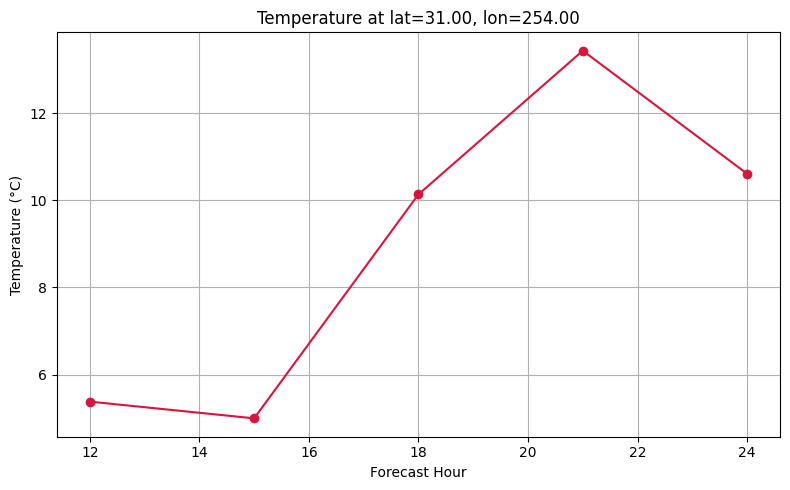

In [ ]:
ds = nc_tmp_2m_latlon

temp = ds.variables["Temperature_height_above_ground"]
fhour = ds.variables["fhour"][:]  # forecast hours
lat = ds.variables["lat"][:]
lon = ds.variables["lon"][:]
for lat_idx, lon_idx in itertools.product(range(len(lat)), range(len(lon))):
  # Extract temps over forecast hours for time=0 and ens=0
  temp_series = temp[0, 0, :, lat_idx, lon_idx] - 273.15  # Convert to °C

  # Plot
  plt.figure(figsize=(8, 5))
  plt.plot(fhour, temp_series, marker='o', linestyle='-', color='crimson')
  plt.title(f"Temperature at lat={lat[lat_idx]:.2f}, lon={lon[lon_idx]:.2f}")
  plt.xlabel("Forecast Hour")
  plt.ylabel("Temperature (°C)")
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  break

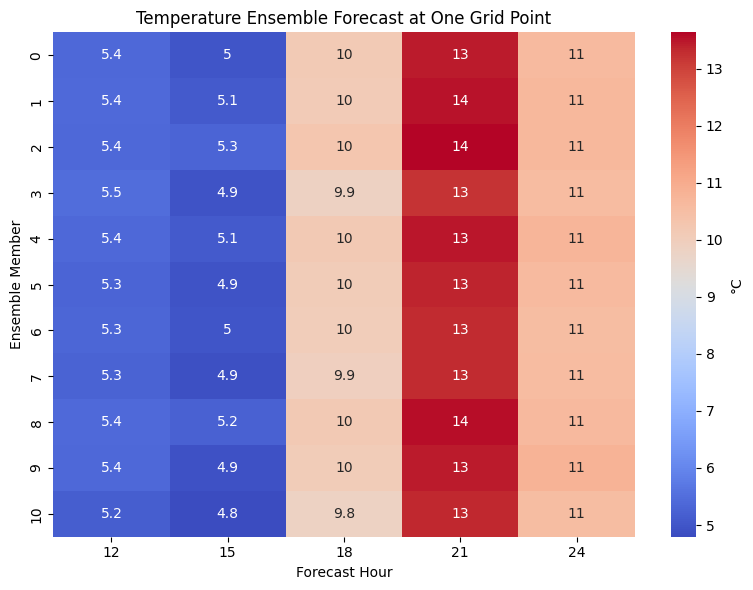

In [ ]:
import seaborn as sns
import numpy as np

# Extract data: time=0, all ensembles, all forecast hours at one point
temps = temp[0, :, :, lat_idx, lon_idx] - 273.15  # shape (ens, fhour)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(temps, annot=True, xticklabels=fhour, cmap="coolwarm", cbar_kws={"label": "°C"})
plt.xlabel("Forecast Hour")
plt.ylabel("Ensemble Member")
plt.title("Temperature Ensemble Forecast at One Grid Point")
plt.tight_layout()
plt.show()

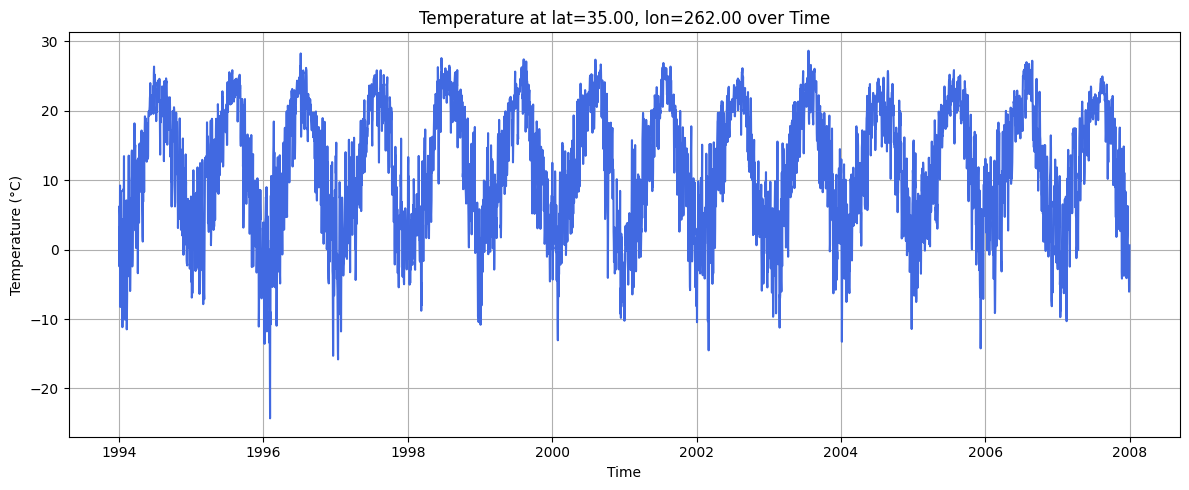

In [ ]:
# Load data
ds = nc_tmp_2m_latlon
temp = ds.variables["Temperature_height_above_ground"]
intTime = ds.variables["intTime"][:]  # shape (5113,)
lat = ds.variables["lat"][:]
lon = ds.variables["lon"][:]

# Convert intTime to datetime
def parse_time(t):
    return datetime.strptime(str(t), "%Y%m%d%H")

times = [parse_time(t) for t in intTime]

# Choose fixed location (center of grid)
lat_idx = len(lat) // 2
lon_idx = len(lon) // 2

# Choose ensemble and fhour index (e.g., control run, forecast hour 0)
ens_idx = 0
fhour_idx = 0

# Extract temperature over all time steps
temp_series = temp[:, ens_idx, fhour_idx, lat_idx, lon_idx] - 273.15  # in °C

# Plot
plt.figure(figsize=(12, 5))
plt.plot(times, temp_series, color='royalblue')
plt.title(f"Temperature at lat={lat[lat_idx]:.2f}, lon={lon[lon_idx]:.2f} over Time")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

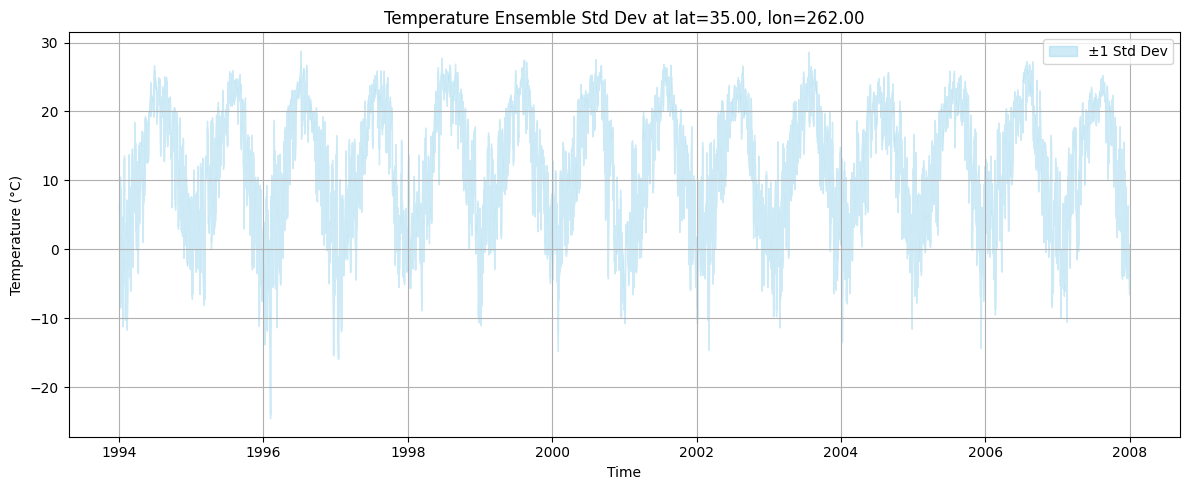

In [ ]:
# Load dataset
ds = nc_tmp_2m_latlon
temp = ds.variables["Temperature_height_above_ground"]
intTime = ds.variables["intTime"][:]
lat = ds.variables["lat"][:]
lon = ds.variables["lon"][:]

# Convert intTime to datetime
def parse_time(t): return datetime.strptime(str(t), "%Y%m%d%H")
times = [parse_time(t) for t in intTime]

# Select grid point and forecast hour
lat_idx = len(lat) // 2
lon_idx = len(lon) // 2
fhour_idx = 0

# Extract data: shape (time, ens)
ens_data = temp[:, :, fhour_idx, lat_idx, lon_idx] - 273.15  # Convert to °C

# Compute mean and std deviation
ens_mean = np.mean(ens_data, axis=1)
ens_std = np.std(ens_data, axis=1)

# Plot
plt.figure(figsize=(12, 5))

# Individual ensemble members (optional)
# for i in range(ens_data.shape[1]):
#     plt.plot(times, ens_data[:, i], color='lightgray', alpha=0.3)

# Mean ± std shaded area
plt.fill_between(times, ens_mean - ens_std, ens_mean + ens_std,
                 color='skyblue', alpha=0.4, label='±1 Std Dev')

# Mean line
# plt.plot(times, ens_mean, color='crimson', linewidth=2, label='Ensemble Mean')

plt.title(f"Temperature Ensemble Std Dev at lat={lat[lat_idx]:.2f}, lon={lon[lon_idx]:.2f}")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


###Preprocessing data for creating training and test dataset

In [ ]:
import glob
def pre_processing(data_dir=f'{train_path}/train/', agg_dims=['hours','ens_models'], crop_gefs_x_start=2, crop_gefs_x_end=6, crop_gefs_y_start=3, crop_gefs_y_end=12):
  """
  Preparation of the dataset for training a model.
  Steps:
  1. Choose a dimension to aggregate the data, forecast hour or ensemble model or both
  2. Crop/Extract the dataset to the region to the grids of the mesonet sites/stations
  3. Loop through and aggregate for each input parameter in training data folder
  """
    # Looping through files holding GEFS data
  files = glob.glob(f'{data_dir}/*.nc')
  for n, f in enumerate(files):
        #print(n,f)
        # Reading data
        nc_ = Dataset(f'{f}')

        # extracting GEFS variable from netcdf
        nc_gefs = list(nc_.variables.values())[-1]

        if agg_dims == 'hours':
            # taking mean of the measurements taken in different times
            #print(f"shape before processing {nc_gefs.shape}")
            nc_agg = np.mean(nc_gefs, axis=2)
            #print("shape after taking mean of hours:")
            #print(nc_agg.shape)

        elif agg_dims == 'ens_models':
            # taking mean of the measurements taken in different times
            #print(f"shape before processing {nc_gefs.shape}")
            nc_agg = np.mean(nc_gefs, axis=1)
            #print("shape after taking mean of hours:")
            #print(nc_agg.shape)

        else:
            # taking mean of the measurements taken in different times
            nc_agg = np.mean(nc_gefs, axis=2)
            #print("shape after taking mean of hours:")
            #print(nc_agg.shape)
            nc_agg = np.mean(nc_agg, axis=1)
            #print("shape after taking mean of ensembles:")
            #print(nc_agg.shape)

        # cropping GEFS based on lat-lon
        if agg_dims == 'hours':
            #print(f"shape before crop {nc_agg.shape}")
            nc_agg_cropped = nc_agg[:,:,crop_gefs_x_start:crop_gefs_x_end,crop_gefs_y_start:crop_gefs_y_end]
            #print(f"shape after crop {nc_agg_cropped.shape}")
        elif agg_dims == 'ens_models':
            #print(f"shape before crop {nc_agg.shape}")
            nc_agg_cropped = nc_agg[:,:, crop_gefs_x_start:crop_gefs_x_end,crop_gefs_y_start:crop_gefs_y_end]
            #print(f"shape after crop {nc_agg_cropped.shape}")
        else:
            #print(f"shape before crop {nc_agg.shape}")
            nc_agg_cropped = nc_agg[:, crop_gefs_x_start:crop_gefs_x_end,crop_gefs_y_start:crop_gefs_y_end]
            #print(f"shape after crop {nc_agg_cropped.shape}")


        # reshaping into 2 dimensions & converting to dataframe
        if agg_dims == 'hours':
            #print("we gotta form the shape dynamically too, rather than just giving the numbers")
            df_gefs_ = pd.DataFrame(nc_agg_cropped.reshape(np.prod(nc_agg_cropped.shape),1)) #5113*4*9*11
        elif agg_dims == 'ens_models':
            #print(nc_agg_cropped.shape)
            df_gefs_ = pd.DataFrame(nc_agg_cropped.reshape(np.prod(nc_agg_cropped.shape)//5,5)) #5113*4*9
        else:
            df_gefs_ = pd.DataFrame(nc_agg_cropped.reshape(np.prod(nc_agg_cropped.shape),1)) #5113*4*9


        # we will use the name of file to rename columns so we don't get confused as we keep appending files
        prefix = f.split('/')[-1].split("latlon")[0]

        # existing columns of dataframe we created
        cols = list(df_gefs_.columns)

        # creating new names for columns
        newcols = [prefix+str(c) for c in cols]

        # creating the dictionary to rename cols accordingly
        rename_cols = {cols[i]: newcols[i] for i in range(len(cols))}

        # changing names on the dataset & inplacing
        df_gefs_ = df_gefs_.rename(rename_cols, axis=1)

        if n == 0:
            latlon = list(itertools.product(nc_['lat'][:][:].data[crop_gefs_x_start:crop_gefs_x_end], nc_['lon'][:][:].data[crop_gefs_y_start:crop_gefs_y_end]))
            df_nc_time = pd.DataFrame(nc_['intValidTime'][:][:].data)
            date_latlon = list(itertools.product(df_nc_time[0].apply(lambda x: int(str(x)[:8])),latlon))
            df_gefs = pd.DataFrame(date_latlon, columns=['date','coordinates'])
            df_gefs = pd.concat([df_gefs,df_gefs_], axis = 1)
            #df_ens = df_ens_[:] # ======> created to do some feature eng on GEFS variables later
        else:
            df_gefs = pd.concat([df_gefs,df_gefs_], axis = 1)
        #print(df_gefs.shape)
  return df_gefs

In [ ]:
from haversine import haversine
def custom_haversine(coord1, coordDf):
    """
    Calculate the great circle distance between two points on the earth (specified in decimal degrees)
    source: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    l={}
    for coord2, n_coord2 in list(zip(coordDf.coord, coordDf.normalized_coord)):
        l[coord2] = haversine(coord1,n_coord2)
    return l

In [ ]:
def get_one_ens(df_gefs, ens_model=0):
    """
    Function to select ensemble model
    """
    # taking only one ensemble model = number 0
    #ens = ['date', 'coordinates']
    ens = [col for col in df_gefs.columns if col.split("_")[-1]==f"{ens_model}" ]
    ens.insert(0,'date')
    ens.insert(1,'coordinates')
    # crop df_gefs based on the ens model we wanna get
    df_gefs_ens = df_gefs[ens]
    return df_gefs_ens

In [ ]:
def get_min_distance_node(df_gefs):
    """
    Mapping the MESONET sites to the closest GEFS point
    Steps:
    1. Normalizes the coordinates of GEFS points (they are greater than 180)
    2. Calculate haversine distance between a mesonet and all GEFS points, puts it into a dict and adds it to station info
    3. Calculate minimum distance & adds coordinate of the related GEFS as another column,
    which will be used in join condition later when training set and labels are combined
    """
    # Get normalized GEFS coordinates
    df_gefs_loc = pd.DataFrame(df_gefs['coordinates'].unique(), columns=['coord'])
    df_gefs_loc['normalized_coord'] = df_gefs_loc['coord'].apply( lambda x: (x[0], x[1]-360))
    # Read mesonet metadata
    df_mes = pd.read_csv(f'{root_dir}/station_info.csv')
    # zip coordinates for later calculations
    df_mes["coord"] = list(zip(df_mes.nlat, df_mes.elon))
    # calculate haversine distances between the area we cropped and mesonets
    df_mes['new_distances'] = df_mes['coord'].apply(lambda x: custom_haversine(x, df_gefs_loc))
    # Find minimum distance GEFS for every mesonet
    df_mes['min_dist_node'] = df_mes['new_distances'].apply(lambda x: list(x.keys())[list(x.values()).index(min(x.values()))])
    return df_mes

In [ ]:
def create_labels(df_gefs_ens, df_mes, df_train_csv):
    """
    Joins labels (daily solar power production) with related GEFS point (closest GEFS in grid)
    """
    # create mesonet list
    mesonets = list(df_mes['stid'])
    # melt training dataframe so mesonets are in rows instead of columns
    df_train = pd.melt(df_train_csv, id_vars='Date', value_vars=mesonets,\
                 var_name='stid', value_name='Daily_Production')
    # combine distance related features from metadata to training data
    df_train = pd.merge(df_train, df_mes[['stid','new_distances','min_dist_node']], on='stid', how='left')
    # create join columns
    df_train['join'] = df_train['Date'].astype(str) + df_train['min_dist_node'].astype(str)
    df_gefs_ens['join'] = df_gefs_ens['date'].astype(str) + df_gefs_ens['coordinates'].astype(str)
    # join two dataframes
    df_train_merged = pd.merge(df_train, df_gefs_ens[['tcolc_eatm_0', 'ulwrf_tatm_0', 'dlwrf_sfc_0','tmp_sfc_0', 'tcdc_eatm_0', 'dswrf_sfc_0', 'tmax_2m_0', 'tmin_2m_0','pwat_eatm_0', 'uswrf_sfc_0', 'spfh_2m_0', 'ulwrf_sfc_0', 'tmp_2m_0','apcp_sfc_0', 'pres_msl_0', 'join']], how='left', on='join')
    return df_train_merged

In [ ]:
import os
#Path to the train folder where all the NetCDF files for parameters are stored
data_dir = f'/content/drive/MyDrive/AI_Sustainability/data/'
#Choose the axis of aggregation
aggs = ['ens_models']
meso_x_start = 2
meso_x_end = 6
meso_y_start = 3
meso_y_end = 12

df_gefs = pre_processing(data_dir, agg_dims=aggs, crop_gefs_x_start=meso_x_start, crop_gefs_x_end=meso_x_end, crop_gefs_y_start=meso_y_start, crop_gefs_y_end=meso_y_end)
df_mes = get_min_distance_node(df_gefs)
df_gefs_ens = get_one_ens(df_gefs, 0)
df_train_csv = pd.read_csv(f'{root_dir}/train.csv')
df_train_merged = create_labels(df_gefs_ens, df_mes, df_train_csv)
#Convert 'Date' column to datetime and filter
df_train_merged['Date'] = pd.to_datetime(df_train_merged['Date'].astype(str), format='%Y%m%d')

# Ensure output directory exists
data_dir = f'{root_dir}/data'
os.makedirs(data_dir, exist_ok=True)

# Training data date range
start_date = '2000-01-01'
end_date = '2004-12-31'
dataset = df_train_merged
train_dataset = dataset[(dataset['Date'] >= start_date) & (dataset['Date'] <= end_date)]
train_dataset.to_csv(f'{data_dir}/train_data_ensemble_0-agg.csv', index=False)

# Test data date range
start_date = '2005-01-01'
end_date = '2005-12-31'

test_dataset = dataset[(dataset['Date'] >= start_date) & (dataset['Date'] <= end_date)]
test_dataset.to_csv(f'{data_dir}/test_data_ensemble_0-agg.csv', index=False)


        Date  stid  Daily_Production  \
0 1994-01-01  ACME          12384900   
1 1994-01-02  ACME          11908500   
2 1994-01-03  ACME          12470700   
3 1994-01-04  ACME          12725400   
4 1994-01-05  ACME          10894800   

                                       new_distances  min_dist_node  \
0  {(33.0, 257.0): 501.30240315332753, (33.0, 258...  (35.0, 262.0)   
1  {(33.0, 257.0): 501.30240315332753, (33.0, 258...  (35.0, 262.0)   
2  {(33.0, 257.0): 501.30240315332753, (33.0, 258...  (35.0, 262.0)   
3  {(33.0, 257.0): 501.30240315332753, (33.0, 258...  (35.0, 262.0)   
4  {(33.0, 257.0): 501.30240315332753, (33.0, 258...  (35.0, 262.0)   

                                            join  tcolc_eatm_0  ulwrf_tatm_0  \
0  19940101(np.float32(35.0), np.float32(262.0))      0.002298    254.383804   
1  19940102(np.float32(35.0), np.float32(262.0))      0.069067    231.387222   
2  19940103(np.float32(35.0), np.float32(262.0))      0.001782    241.279846   
3  19940104(

###Understanding Temporal Patterns of target Solar Energy Production

<ipython-input-54-b1c92c657401>:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df['avg_energy'].resample('M').mean()
<ipython-input-54-b1c92c657401>:18: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  seasonal = df['avg_energy'].resample('Q').mean()


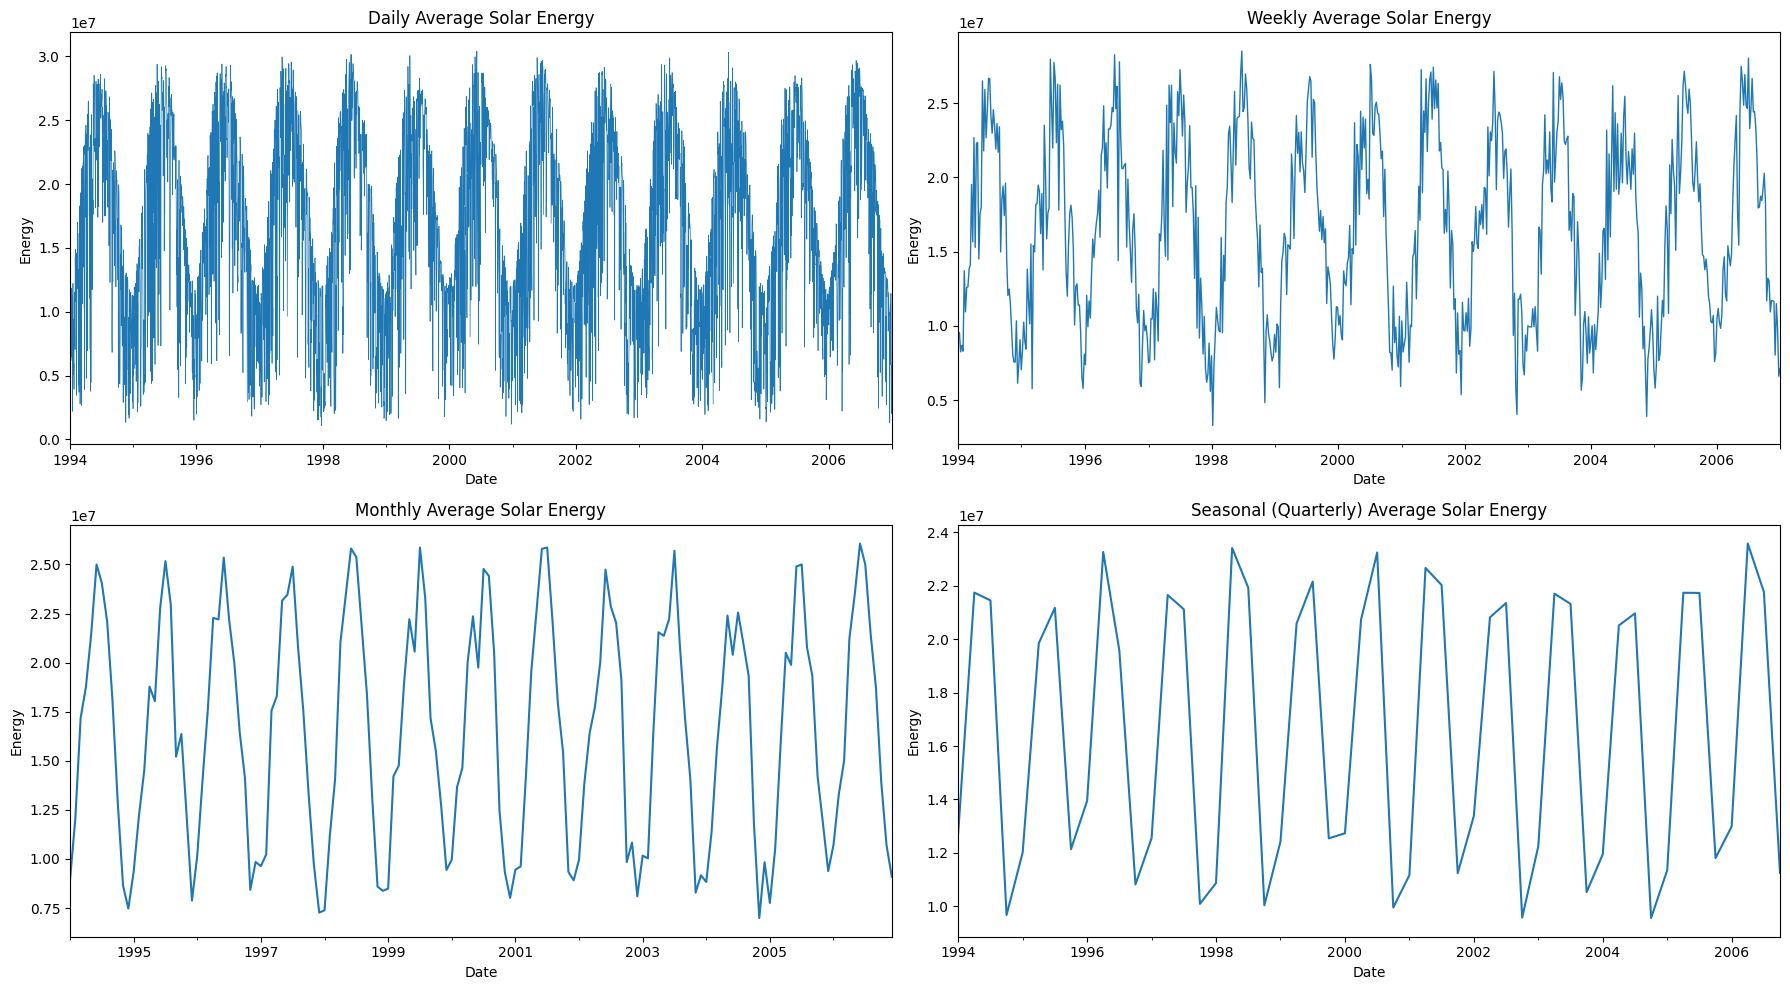

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv(f'{root_dir}/train.csv')
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

# Set Date as the index
df.set_index('Date', inplace=True)

df = df.loc['1994-01-01':'2006-12-31']
# Calculate average solar energy across all stations for each day
df['avg_energy'] = df.mean(axis=1)

# Resample to get different time resolutions
daily = df['avg_energy']
weekly = df['avg_energy'].resample('W').mean()
monthly = df['avg_energy'].resample('M').mean()
seasonal = df['avg_energy'].resample('Q').mean()

# Plotting
plt.figure(figsize=(18, 10))
plt.subplot(2, 2, 1)
daily.plot(title='Daily Average Solar Energy', linewidth=0.5)
plt.ylabel('Energy')

plt.subplot(2, 2, 2)
weekly.plot(title='Weekly Average Solar Energy', linewidth=1)
plt.ylabel('Energy')

plt.subplot(2, 2, 3)
monthly.plot(title='Monthly Average Solar Energy')
plt.ylabel('Energy')

plt.subplot(2, 2, 4)
seasonal.plot(title='Seasonal (Quarterly) Average Solar Energy')
plt.ylabel('Energy')

plt.tight_layout()
plt.show()


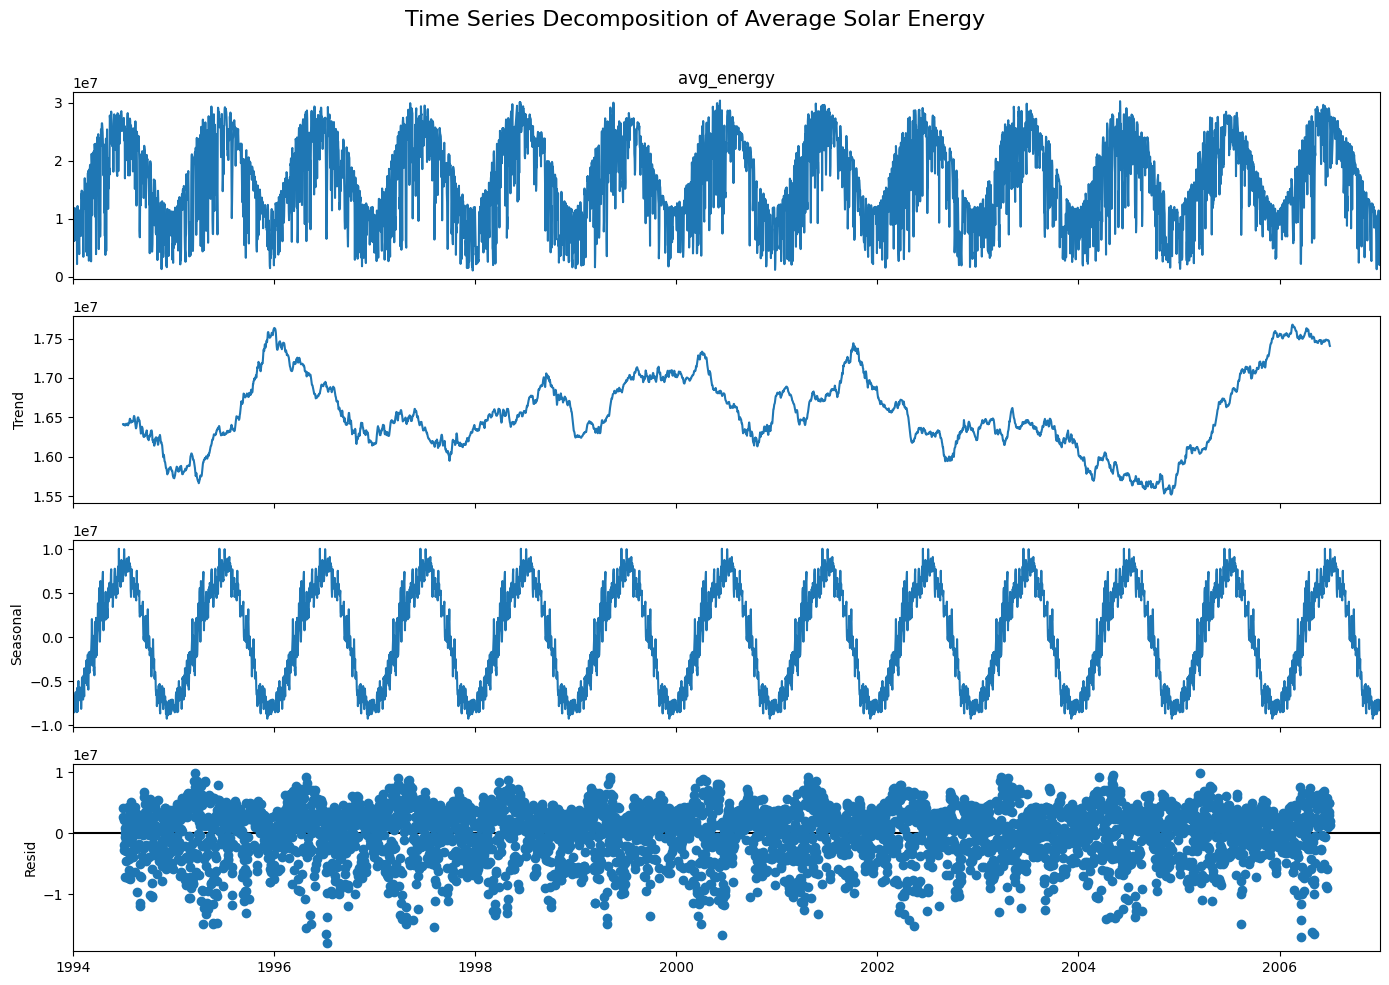

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
df = pd.read_csv(f'{root_dir}/train.csv')
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

# Set Date as the index
df.set_index('Date', inplace=True)

df = df.loc['1994-01-01':'2006-12-31']
# Calculate average solar energy across all stations for each day
df['avg_energy'] = df.mean(axis=1)
daily = df['avg_energy']

# monthly = df['avg_energy'].resample('M').mean()

# Resample to get different time resolutions
daily = df['avg_energy']
# Decompose the daily average energy series
decomposition = seasonal_decompose(daily, model='additive', period=365)
print(decomposition)
# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Time Series Decomposition of Average Solar Energy', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

###Understanding station wise (MesoNet) Solar Energy Production

<ipython-input-61-947c2dd361f8>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_stats['Median Deviation'], y=sorted_stats.index, palette='coolwarm')


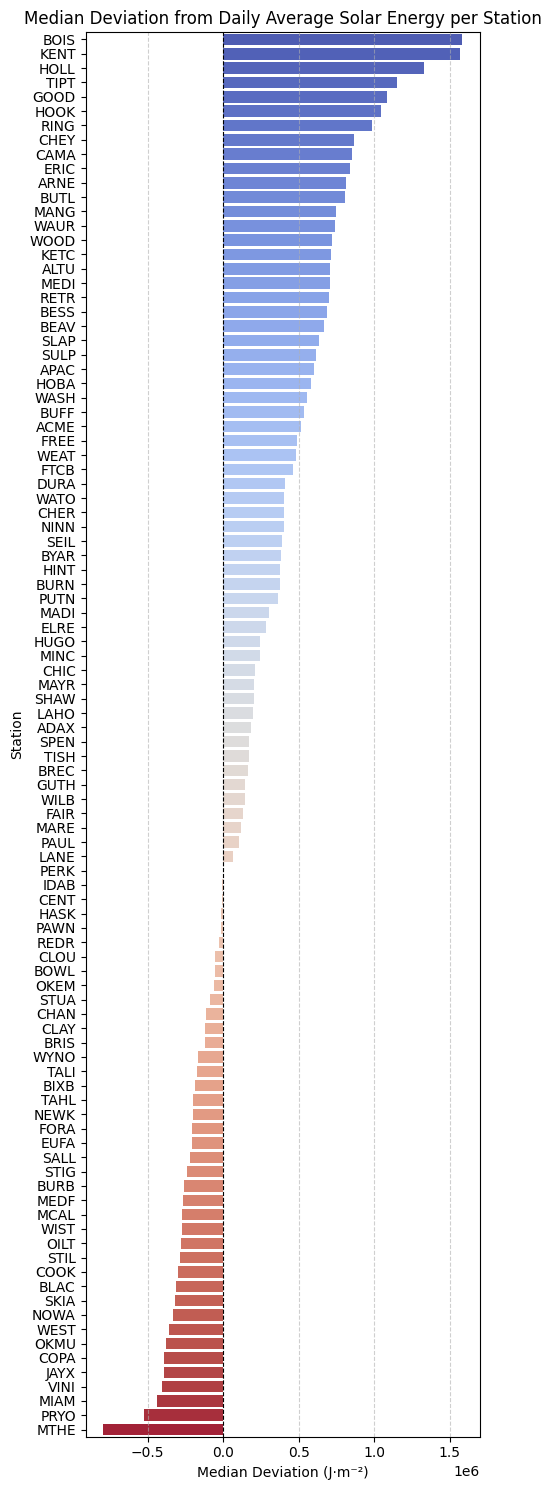

In [ ]:
# Plot the median deviations for all stations, sorted
import matplotlib.pyplot as plt
# Remove the 'Date' column to focus on station data
df = pd.read_csv(f'{root_dir}/train.csv')
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
stations_df = df.drop(columns=['Date'])

# Calculate daily averages across all stations
daily_avg = stations_df.mean(axis=1)

# Calculate deviation from the daily average for each station
deviations = stations_df.subtract(daily_avg, axis=0)

# Compute statistics per station
station_stats = pd.DataFrame({
    'Mean Deviation': deviations.mean(),
    'Median Deviation': deviations.median(),
    'Standard Deviation': deviations.std()
})

# Sort stations by median deviation for plotting
sorted_stats = station_stats.sort_values(by='Median Deviation', ascending=False)

# Plot
plt.figure(figsize=(5, 15))
sns.barplot(x=sorted_stats['Median Deviation'], y=sorted_stats.index, palette='coolwarm')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Median Deviation from Daily Average Solar Energy per Station')
plt.xlabel('Median Deviation (J·m⁻²)')
plt.ylabel('Station')
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()
